# Machine Learning avy_wx Data (focus on deb_rail)
#### MaryGrace Kane + Mr.Gorton guidance (aka stolen notebook)

In [133]:
import pandas as pd

avy_wx = pd.read_pickle('data-prep/pkl/avywx2.pkl')
# avy_wx

In [134]:
# avy_wx.info()

### Features I think we can use

Why do I think we can use these? Most of the avy obs data was observed after the target event (deb_rail) and would cause data leakage if we were to use it. 

I chose to include `ch_max_cm` because I theorize that a snow pit might be able to help determine what that value would be.

In [135]:
fitwcu = ['avpathid', 'ch_max_cm', 'temp', 'dew_pt', 'rH', 'snow_depth', 'snowfall_3hr', 'snowfall_6hr', 'snowfall_24hr']
# fitwcu = ['avpathid', 'temp', 'dew_pt', 'rH', 'snow_depth', 'snowfall_3hr', 'snowfall_6hr', 'snowfall_24hr']
# fitwcu = ['avpathid', 'ch_max_cm']

# TODO: add wind_spd (needs to be parsed)
# TODO: date? days into season?

# tts_rnd = 2 # use this to change the train_test_split random state

### Separating X & y

In [136]:
X = avy_wx[fitwcu]
y = avy_wx['deb_rail']

### Separating Columns according to dtypes

In [137]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns
other_cols = X.select_dtypes(exclude=['object', 'number']).columns

print(cat_cols)
print(num_cols)
print(other_cols)

Index(['avpathid'], dtype='object')
Index(['ch_max_cm', 'temp', 'dew_pt', 'rH', 'snow_depth', 'snowfall_3hr',
       'snowfall_6hr', 'snowfall_24hr'],
      dtype='object')
Index([], dtype='object')


### Splitting into X_train, y_train, X_valid, y_valid

In [138]:
from sklearn.model_selection import train_test_split

def tts(tts_rnd):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=tts_rnd)
    return X_train, X_valid, y_train, y_valid

### Determining Which Columns Are Missing Values

I actually don't care. The SimpleImputer will only act of NaN values and the OHE will ignore NaN's.

In [139]:
# avy_wx[num_cols].isnull().any()

In [140]:
# cols_missing_num = [col for col in X[num_cols] if X[col].isnull().any() == True]
# cols_missing_num

In [141]:
# X[cat_cols].isnull().any()

In [142]:
# cols_missing_cat = [col for col in X[cat_cols] if X[col].isnull().any() == True]
# cols_missing_cat

In [143]:
# full_cols = [col for col in X.columns if X[col].isnull().any() == False]
# full_cols

### Imputation of Numerical Columns

In [144]:
from sklearn.impute import SimpleImputer

def impute_num_data(X_train, X_valid):
    imputer = SimpleImputer()

    imputer_X_train = pd.DataFrame(imputer.fit_transform(X_train[num_cols]))
    imputer_X_valid = pd.DataFrame(imputer.transform(X_valid[num_cols]))

    imputer_X_train.columns = num_cols
    imputer_X_valid.columns = num_cols

    imputer_X_train.index = X_train.index
    imputer_X_valid.index = X_valid.index

    return imputer_X_train, imputer_X_valid

### Checking Number of Unique Values per Categorical Column

This is great for determining whether the cardinality of a column precludes one-hot encoding. In the case or `avrid`, it does not.

In [145]:
# object_nunique = list(map(lambda col: X_train[col].nunique(), cols_missing_cat))
# d = dict(zip(cols_missing_cat, object_nunique))

# sorted(d.items(), key=lambda x: x[1])

In [146]:
from sklearn.preprocessing import OneHotEncoder

def ohe_cat_data(X_train, X_valid, imputer_X_train, imputer_X_valid):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cat_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[cat_cols]))

    OH_cols_train.index = X_train.index
    OH_cols_valid.index = X_valid.index

    OH_cols_train.columns = OH_encoder.get_feature_names_out()
    OH_cols_valid.columns = OH_encoder.get_feature_names_out()

    # this is a little different than what MG did
    full_X_train = pd.concat([imputer_X_train, OH_cols_train], axis=1)
    full_X_valid = pd.concat([imputer_X_valid, OH_cols_valid], axis=1)

    return full_X_train, full_X_valid
# use if no num cols
# full_X_train = OH_cols_train.copy()
# full_X_valid = OH_cols_valid.copy()

In [147]:
# is this set to go?
# full_X_train.info()

### Comparing Classifiers

##### Decision Tree Classifier

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def run_dtc_model(full_X_train, full_X_valid, y_train, y_valid):

    dtc_model = DecisionTreeClassifier(random_state=0)

    dtc_model.fit(full_X_train, y_train)

    dtc_val_predictions = dtc_model.predict(full_X_valid)

    print("Accuracy of DecisionTree:", accuracy_score(dtc_val_predictions, y_valid))
    return dtc_model

##### Random Forest Classifier

In [149]:
from sklearn.ensemble import RandomForestClassifier

def run_rf_model(full_X_train, full_X_valid, y_train, y_valid):
    rf_model = RandomForestClassifier(random_state = 1)
    rf_model.fit(full_X_train, y_train)

    rf_val_predictions = rf_model.predict(full_X_valid)

    print("Accuracy of RandomForest:", accuracy_score(rf_val_predictions, y_valid))

##### Gaussian Naive Bayes Classifier

In [150]:
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB

def run_gnb_model(full_X_train, full_X_valid, y_train, y_valid):
    X, y = load_iris(return_X_y=True)
    gnb = GaussianNB()
    gnb_pred = gnb.fit(full_X_train, y_train).predict(full_X_valid)
    print("Accuracy of GaussianNB:", accuracy_score(gnb_pred, y_valid))

##### Gradient Boosting Classifier

In [151]:
from sklearn.ensemble import GradientBoostingClassifier

def run_gb_model(full_X_train, full_X_valid, y_train, y_valid):
    gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
    # gradient_booster.get_params()
    gbc_pred = gradient_booster.fit(full_X_train,y_train).predict(full_X_valid)
    print("Accuracy of GradientBoosting:", accuracy_score(gbc_pred, y_valid))

### Playing with tts_rnd

In [152]:
tts_rnd_samples = [1,2,3,5]

for s in tts_rnd_samples:
    print('tts Random State:', s)
    X_train, X_valid, y_train, y_valid = tts(s)
    imputer_X_train, imputer_X_valid = impute_num_data(X_train, X_valid)
    full_X_train, full_X_valid = ohe_cat_data(X_train, X_valid, imputer_X_train, imputer_X_valid)
    run_dtc_model(full_X_train, full_X_valid, y_train, y_valid)
    run_rf_model(full_X_train, full_X_valid, y_train, y_valid)
    run_gnb_model(full_X_train, full_X_valid, y_train, y_valid)
    run_gb_model(full_X_train, full_X_valid, y_train, y_valid)

tts Random State: 1
Accuracy of DecisionTree: 0.8780487804878049
Accuracy of RandomForest: 0.8943089430894309
Accuracy of GaussianNB: 0.3821138211382114
Accuracy of GradientBoosting: 0.8861788617886179
tts Random State: 2
Accuracy of DecisionTree: 0.9024390243902439
Accuracy of RandomForest: 0.9105691056910569
Accuracy of GaussianNB: 0.5365853658536586
Accuracy of GradientBoosting: 0.9105691056910569
tts Random State: 3
Accuracy of DecisionTree: 0.9186991869918699
Accuracy of RandomForest: 0.9024390243902439
Accuracy of GaussianNB: 0.4634146341463415
Accuracy of GradientBoosting: 0.926829268292683
tts Random State: 5
Accuracy of DecisionTree: 0.9105691056910569
Accuracy of RandomForest: 0.9024390243902439
Accuracy of GaussianNB: 0.43089430894308944
Accuracy of GradientBoosting: 0.9105691056910569


### Visualize Decision Tree

About the coolest thing ever

In [157]:
X_train, X_valid, y_train, y_valid = tts(3)
imputer_X_train, imputer_X_valid = impute_num_data(X_train, X_valid)
full_X_train, full_X_valid = ohe_cat_data(X_train, X_valid, imputer_X_train, imputer_X_valid)
dtc_model = run_dtc_model(full_X_train, full_X_valid, y_train, y_valid)

Accuracy of DecisionTree: 0.9186991869918699


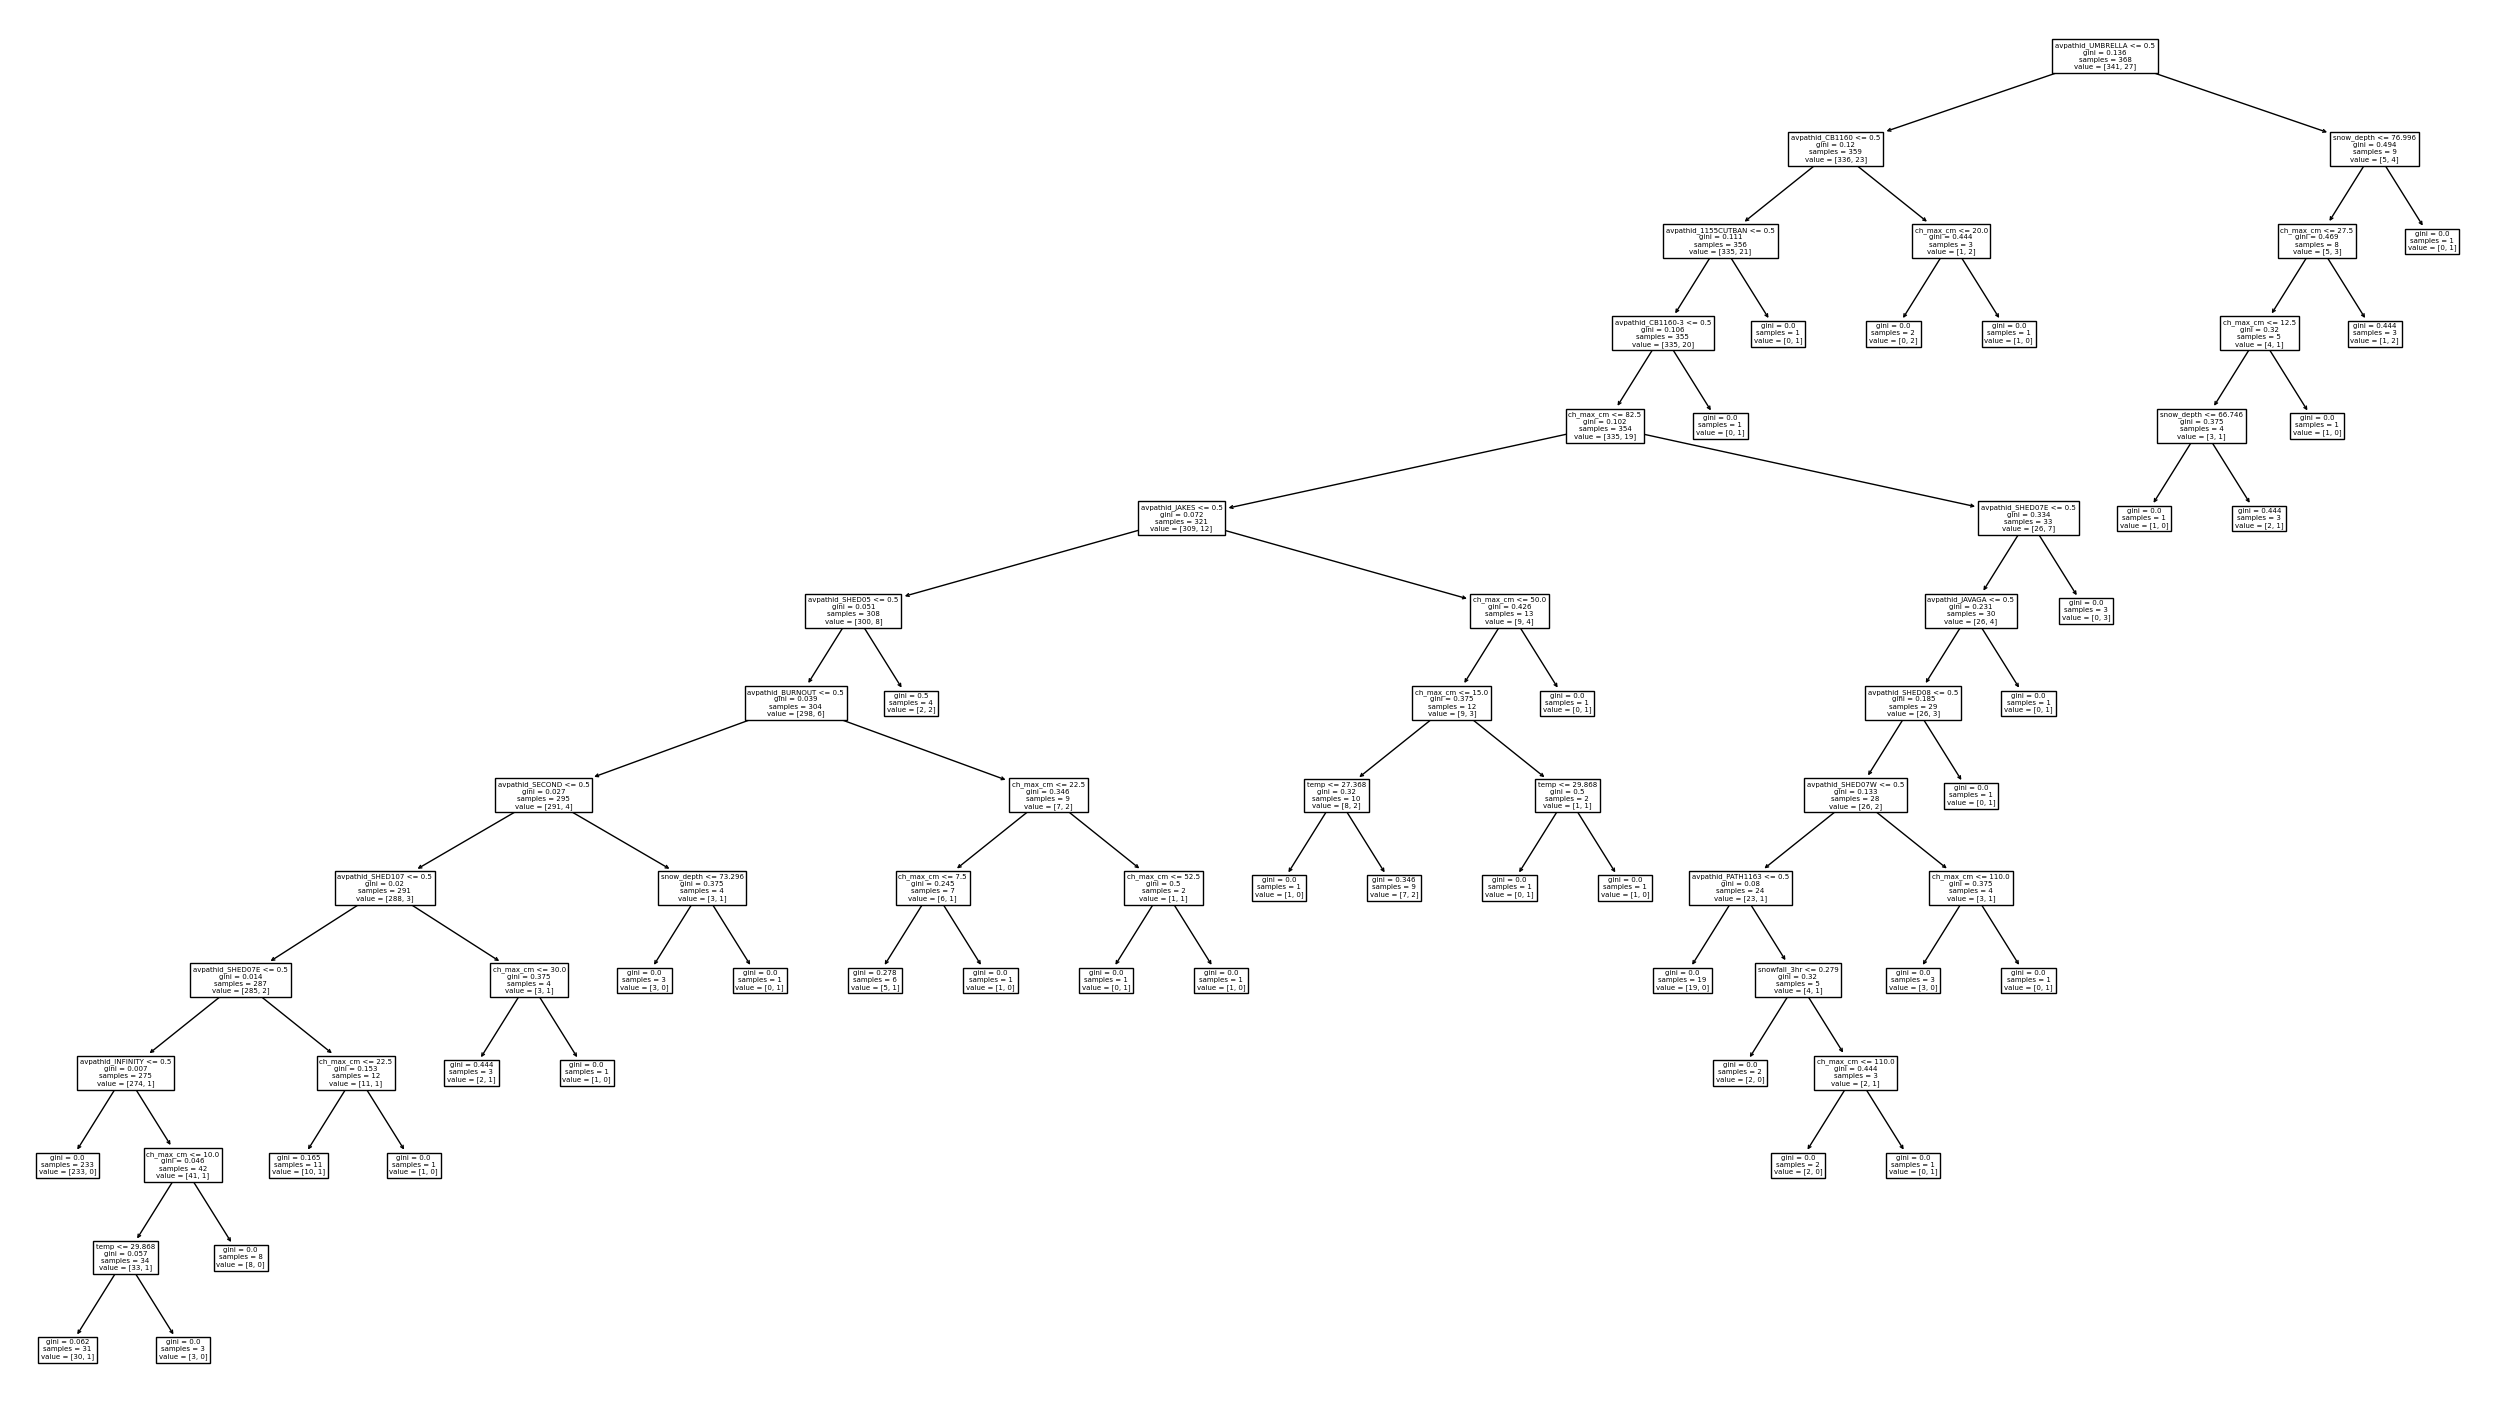

In [158]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(32,18))
tree.plot_tree(dtc_model, feature_names=full_X_train.columns)
plt.show()